In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import numpy as np
import cv2
from deepface.extendedmodels import Emotion
from deepface.commons import functions, distance as dst

In [2]:
#building the base model for calling the emotion detection or other models
def build_model(model_name):

    global model_obj

    models = {
        "Emotion": Emotion.loadModel,
    }

    if not "model_obj" in globals():
        model_obj = {}

    if not model_name in model_obj:
        model = models.get(model_name)
        if model:
            model = model()
            model_obj[model_name] = model
        else:
            raise ValueError(f"Invalid model_name passed - {model_name}")

    return model_obj[model_name]

Action: emotion: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Congratulations, you got the base point! Happy index: 98.74408260058372


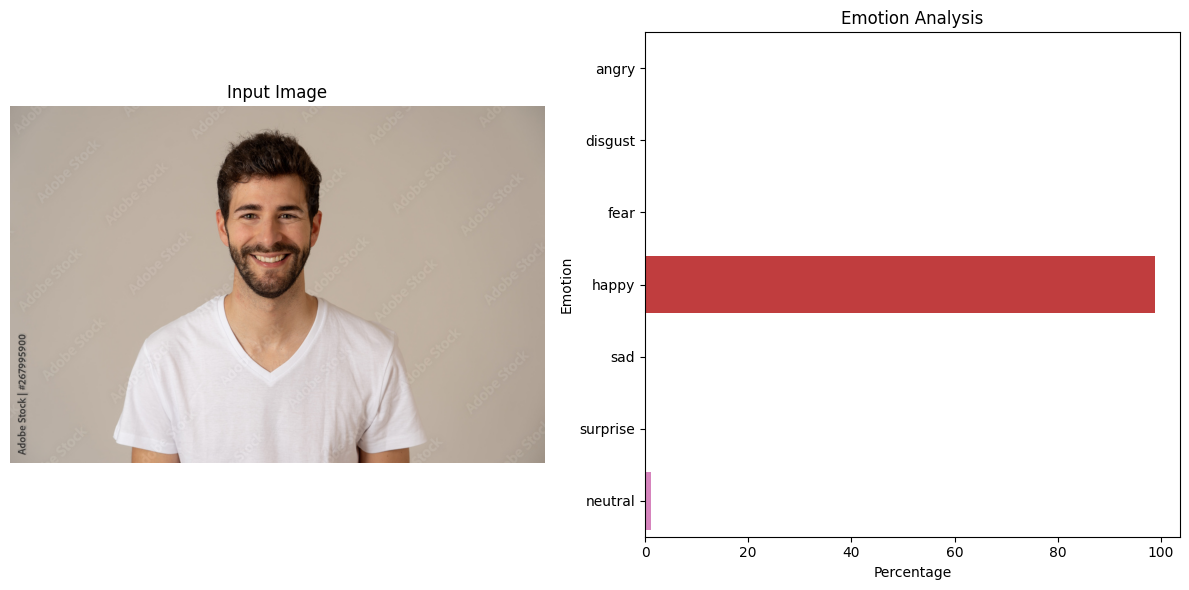

[{'emotion': {'angry': 0.0007990330189105809, 'disgust': 3.719389863469707e-06, 'fear': 3.9834845691773e-05, 'happy': 98.74408260058372, 'sad': 0.02224799125898361, 'surprise': 0.008157694292781065, 'neutral': 1.2246646389764977}, 'dominant_emotion': 'happy', 'region': {'x': 381, 'y': 120, 'w': 206, 'h': 206}, 'face_confidence': 8.633828028629068}]
Base point = 1
Performance point = 3


In [3]:
input_image=(r'C:\Users\user\Downloads\happy-human.jpg')
base_point=0
#the following function takes a picture as input and will run facial emotion analysis
def Seyyedi_analyze(
    img_path,
    actions=("emotion"),
    enforce_detection=True,
    detector_backend="opencv",
    align=True,
    silent=False,
    models=None,
):

    # validate actions
    if isinstance(actions, str):
        actions = (actions,)

    # check if actions is not an iterable or empty.
    if not hasattr(actions, "__getitem__") or not actions:
        raise ValueError("`actions` must be a list of strings.")

    actions = list(actions)

    # Load pre-trained models if not provided
    if models is None:
        models = {
            "emotion": build_model("Emotion")}

    resp_objects = []

    img_objs = functions.extract_faces(
        img=img_path,
        target_size=(224, 224),
        detector_backend=detector_backend,
        grayscale=False,
        enforce_detection=enforce_detection,
        align=align,
    )

    for img_content, img_region, img_confidence in img_objs:
        if img_content.shape[0] > 0 and img_content.shape[1] > 0:
            obj = {}
            # facial attribute analysis
            pbar = tqdm(range(0, len(actions)), desc="Finding actions", disable=silent)
            for index in pbar:
                action = actions[index]
                pbar.set_description(f"Action: {action}")

                if action == "emotion":
                    img_gray = cv2.cvtColor(img_content[0], cv2.COLOR_BGR2GRAY)
                    img_gray = cv2.resize(img_gray, (48, 48))
                    img_gray = np.expand_dims(img_gray, axis=0)

                    emotion_predictions = models["emotion"].predict(img_gray, verbose=0)[0, :]

                    sum_of_predictions = emotion_predictions.sum()

                    obj["emotion"] = {}

                    for i, emotion_label in enumerate(Emotion.labels):
                        emotion_prediction = 100 * emotion_predictions[i] / sum_of_predictions
                        obj["emotion"][emotion_label] = emotion_prediction

                    obj["dominant_emotion"] = Emotion.labels[np.argmax(emotion_predictions)]



                # -----------------------------
                # mention facial areas
                obj["region"] = img_region
                # include image confidence
                obj["face_confidence"] = img_confidence

            resp_objects.append(obj)
            

    return resp_objects



# Define emotion mapping
emotion_mapping = {
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral",
}
#visualizing the processed info and creating the Acting Test agent
results = Seyyedi_analyze(input_image)
plt.figure(figsize=(12, 6))
img=cv2.imread(input_image)
# Ask user for the desired emotion
emotion_input = int(input("Enter a number between 1-7 for the emotion (1: disgust, 2: fear, 3: happy, 4: sad, 5: surprise, 6: neutral):  "))
desired_emotion = emotion_mapping.get(emotion_input)

if desired_emotion:
    # Extract the specific emotion score
    emotion_score = results[0]["emotion"].get(desired_emotion, 0)

    # Check acting performance
    if emotion_score > 70:
        base_point+=1
        print(f"Congratulations, you got the base point! {desired_emotion.capitalize()} index: {emotion_score}")
        if 70 <= emotion_score < 80:
            performance_points = 1
        elif 80 <= emotion_score < 90:
            performance_points = 2
        elif 90 <= emotion_score < 99:
            performance_points = 3
        elif emotion_score >= 99:
            performance_points = 4

        # Visualizing the results
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Input Image')
        plt.axis('off')
        emotion_data = results[0]['emotion']
        plt.subplot(1, 2, 2)
        sns.barplot(x=list(emotion_data.values()), y=list(emotion_data.keys()), orient='h')
        plt.title('Emotion Analysis')
        plt.xlabel('Percentage')
        plt.ylabel('Emotion')
        plt.tight_layout()
        plt.show()
        print(results)
        print(f"Base point = {base_point}")
        print(f"Performance point = {performance_points}")
    else:
        print(f"You have failed. {desired_emotion.capitalize()} point: {emotion_score}. Base point: {base_point}")
else:
    print("Invalid emotion input. Please enter a number between 1 and 6.")

In [4]:
#creating the real-time Acting Test
def Seyyedi_stream():
    # Open the camera
    cap = cv2.VideoCapture(0)

    # Variables for tracking points
    base_points = 0
    performance_points = 0
    total_tests = 0

    while True:
        # Ask the user to input a number between 1-7
        emotion_number = int(input("Enter a number between 1-7 for the emotion (1: disgust, 2: fear, 3: happy, 4: sad, 5: surprise, 6: neutral, 7: exit): "))

        # Mapping emotion numbers to labels
        emotion_mapping = {
            1: "disgust",
            2: "fear",
            3: "happy",
            4: "sad",
            5: "surprise",
            6: "neutral",
            7: "exit"
        }

        # Validate the input
        if emotion_number not in emotion_mapping:
            print("Invalid input. Exiting.")
            break

        # Exit the loop if the user chooses to exit
        if emotion_number == 7:
            break

        selected_emotion = emotion_mapping[emotion_number]

        # Countdown message
        countdown_message = f"Make a {selected_emotion} face!"

        # Loop to capture frames every 5 seconds
        while True:
            # Display countdown message on the upper left side of the camera feed
            ret, frame = cap.read()
            height, width, _ = frame.shape

            # Display the camera feed
            cv2.imshow("Camera Feed", frame)

            # Wait for 5 seconds
            cv2.putText(frame, countdown_message, (int(width * 0.05), int(height * 0.1)),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.waitKey(5000)

            # Take a screenshot from the camera feed
            ret, screenshot = cap.read()

            # Get user input for specific emotion
            emotion_input = selected_emotion

            # Analyze emotions using noah_analyze function
            results = Seyyedi_analyze(screenshot)

            # Extract the specific emotion score
            emotion_score = results[0]["emotion"].get(emotion_input, 0)

            # Check if the emotion score is above 70
            if emotion_score > 70:
                print(f"Congratulations, you got the base point! {emotion_input.capitalize()} point: {emotion_score}")
                base_points += 1

                # Calculate performance points based on the emotion score
                if 70 <= emotion_score < 80:
                    performance_points += 1
                elif 80 <= emotion_score < 90:
                    performance_points += 2
                elif 90 <= emotion_score < 99:
                    performance_points += 3
                elif emotion_score >= 99:
                    performance_points += 4

                # Print the total points
                print(f"Base point = {base_points}")
                print(f"Performance point = {performance_points}")

            else:
                print(f"You have failed. {emotion_input.capitalize()} point: {emotion_score}. Base point: {base_points}")

            # Plotting the result using matplotlib
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))

            # Display the camera screenshot on the left side
            axs[0].imshow(cv2.cvtColor(screenshot, cv2.COLOR_BGR2RGB))
            axs[0].axis("off")

            # Create a horizontal bar plot for emotions on the right side
            emotions = results[0]["emotion"]
            emotions_labels = list(emotions.keys())
            emotions_values = list(emotions.values())
            axs[1].barh(emotions_labels, emotions_values, color='skyblue')
            axs[1].set_title("Emotions")
            axs[1].set_xlabel("Percentage")

            # Show the plot
            plt.show()

            # Close the plot
            plt.close()
            
            total_tests+=1
            if total_tests > 0:
                average_performance_score = performance_points / total_tests
                print(f"Average Performance Score: {average_performance_score:.2f}")
            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Release the camera before starting a new loop
        cap.release()
        cv2.destroyAllWindows()
        cap = cv2.VideoCapture(0)

    # Release the camera after exiting the main loop
    cap.release()
    cv2.destroyAllWindows()
    print("The total number of tests was:",total_tests)
    print("The total base points earned was:",base_points)
    print("The total performance points earned was:",performance_points)


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


Congratulations, you got the base point! Neutral point: 99.78812336921692
Base point = 1
Performance point = 4


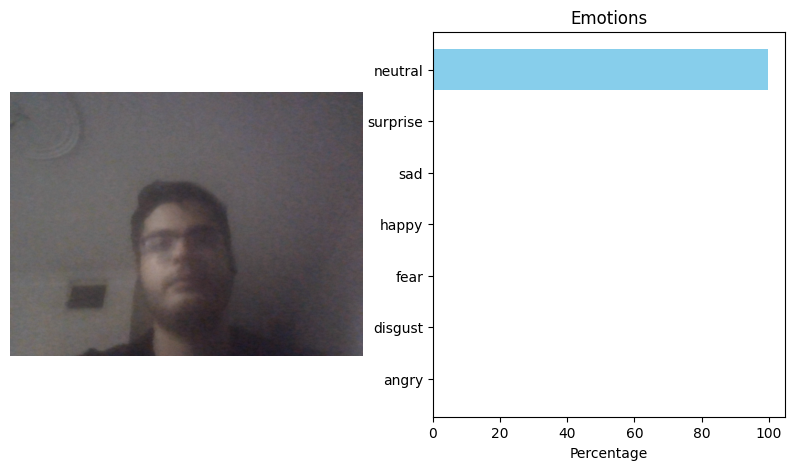

Average Performance Score: 4.00


Action: emotion: 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


Congratulations, you got the base point! Neutral point: 94.26948990043938
Base point = 2
Performance point = 7


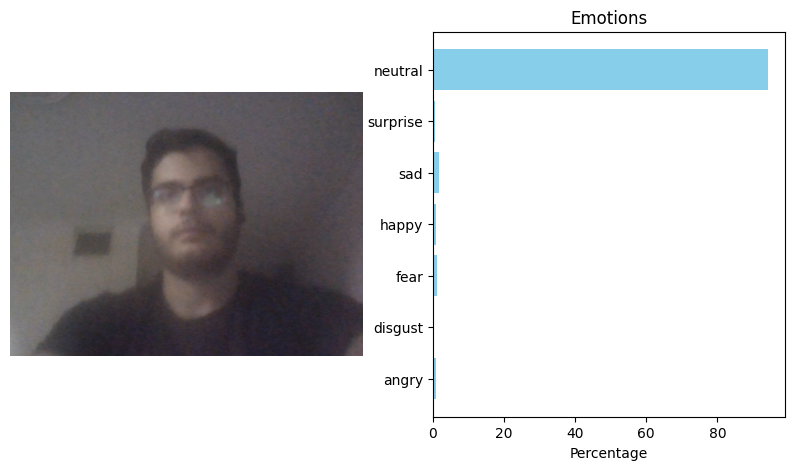

Average Performance Score: 3.50


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


Congratulations, you got the base point! Neutral point: 95.8081841468811
Base point = 3
Performance point = 10


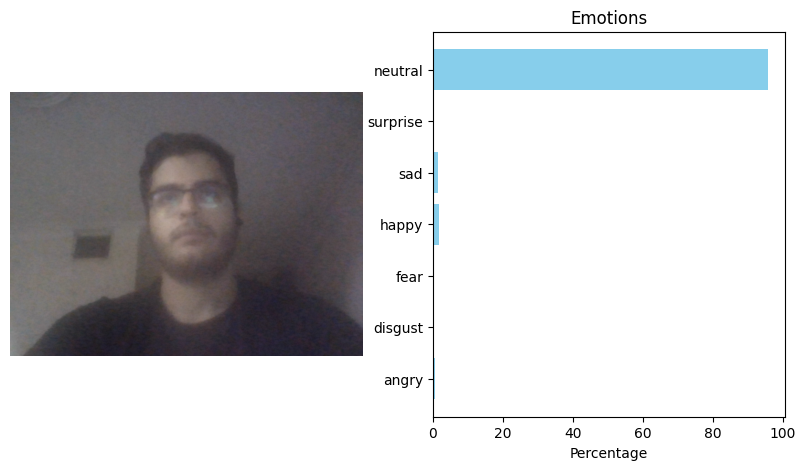

Average Performance Score: 3.33


Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


You have failed. Neutral point: 2.198106050491333. Base point: 3


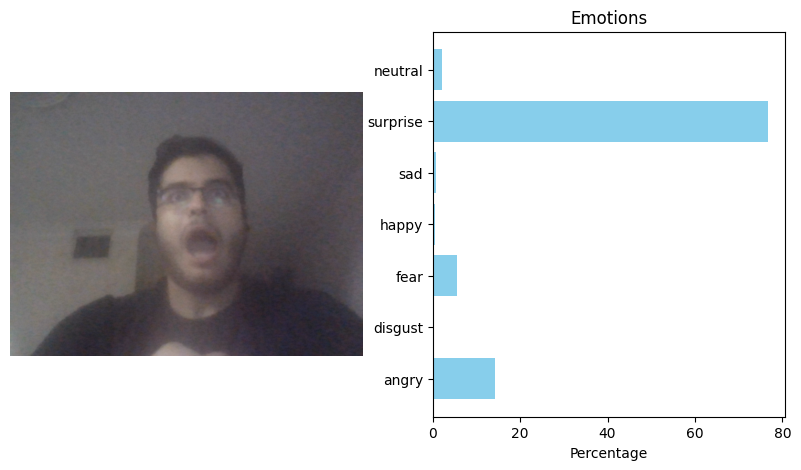

Average Performance Score: 2.50


Action: emotion: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


Congratulations, you got the base point! Happy point: 98.09316992759705
Base point = 4
Performance point = 13


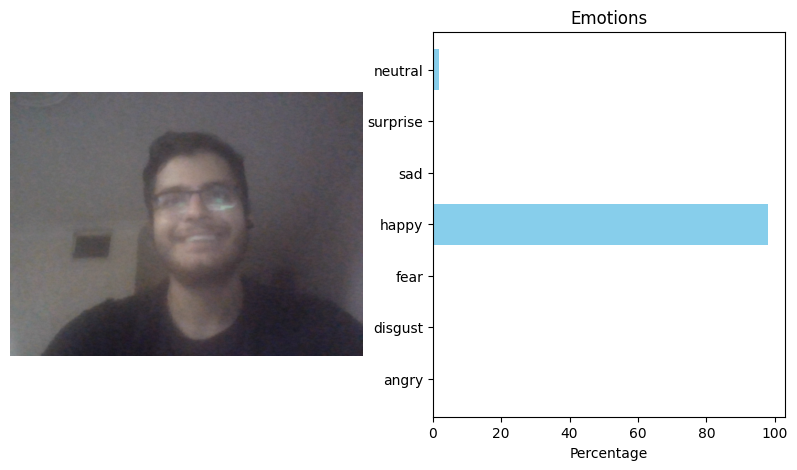

Average Performance Score: 2.60
The total number of tests was: 5
The total base points earned was: 4
The total performance points earned was: 13


In [5]:
Seyyedi_stream()